# Analyse Bevölkerungsbefragung Stadt Zürich

### Autorin: Tabea Eggler

# 1. Daten

### 1.1 Beschreibung der Daten

- Datensatz: Bevölkerungumfrage der Stadt Zürich
- Zeitraum: 2019, 2021, 2023
- Analysierte Frageblöcke: Zufriedenheit mit den Einrichtungen und Angeboten der Stadt (F4) und Zufriedenheit mit den Gegebenheiten im Quartier (F25)
- Variabel Typen: Qualitativ/Kategorisch, Polytomous, Ordinal
- Variabel Levels: Überhaupt nicht zufrieden (1) - Sehr zufrieden (6), Weiss nicht, Keine Angabe

### 1.2 Selektion Variabeln

Primäre Variabel: Zufriedenheit Grünraum im Quartier (F25, A3016ae01)

Sekundäre Variabeln:
- Zufriedenheit Angebot Grünanlagen und Parks (F4, A2004ac01)
- Zufriedenheit Freizeitgestaltung im Quartier (F25, A3016ad01)

Zusätzlich geladene Variabel
- Jahr

### 1.3 Datensatz laden und strukturieren

In [4]:
# load libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

from scipy.stats import spearmanr
from scipy.stats import chi2_contingency
import statsmodels.api as sm

In [6]:
# load dataset

columns_to_load = [
    'A2004ac01',  # satisfaction with greenspace in city
    'A3016ae01',  # satisfaction with greenspace in district
    'A3016ad01',  # satisfaction with leisure
    'Jahr'       # year
]

file_path = 'data/data_stez_2019_2023.csv'
df = pd.read_csv(file_path, usecols=columns_to_load)

In [7]:
# rename columns

df.rename(columns={
    'A2004ac01': 'Satisfaction_GreenSpace_City',
    'A3016ae01': 'Satisfaction_GreenSpace_District',
    'A3016ad01': 'Satisfaction_Leisure',
    'Jahr': 'Year'
}, inplace=True)

In [8]:
# mapping for ordinal data (object to numeric)

satisfaction_mapping = {
    'Note 1 (überhaupt nicht zufrieden)': 1,
    'Note 2': 2,
    'Note 3': 3,
    'Note 4': 4,
    'Note 5': 5,
    'Note 6 (sehr zufrieden)': 6,
    'Weiss nicht': -1,
    'Keine Angabe': -1
}

# apply mapping
ordinal_columns = ['Satisfaction_GreenSpace_City', 'Satisfaction_GreenSpace_District', 'Satisfaction_Leisure']
for col in ordinal_columns:
    df[col] = pd.to_numeric(df[col].replace(satisfaction_mapping), errors='coerce')
    
    
df.head()

/var/folders/7k/528cxkys5vv34d3vcx99jrwh0000gn/T/ipykernel_42103/3399057229.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = pd.to_numeric(df[col].replace(satisfaction_mapping), errors='coerce')


,Year,Satisfaction_GreenSpace_City,Satisfaction_Leisure,Satisfaction_GreenSpace_District
0,2019,5,3,3
1,2019,5,4,5
2,2019,6,6,6
3,2019,6,6,6
4,2019,5,6,6


In [9]:
# info about dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15615 entries, 0 to 15614
Data columns (total 4 columns):
 #   Column                            Non-Null Count  Dtype
---  ------                            --------------  -----
 0   Year                              15615 non-null  int64
 1   Satisfaction_GreenSpace_City      15615 non-null  int64
 2   Satisfaction_Leisure              15615 non-null  int64
 3   Satisfaction_GreenSpace_District  15615 non-null  int64
dtypes: int64(4)
memory usage: 488.1 KB
None


In [10]:
# check for missing values
print(df.isnull().sum())

Year                                0
Satisfaction_GreenSpace_City        0
Satisfaction_Leisure                0
Satisfaction_GreenSpace_District    0
dtype: int64


# 2. Explorative Datenanalyse

### 2.1 Überischt Verteilung über Jahre (Grouped Bar Charts)

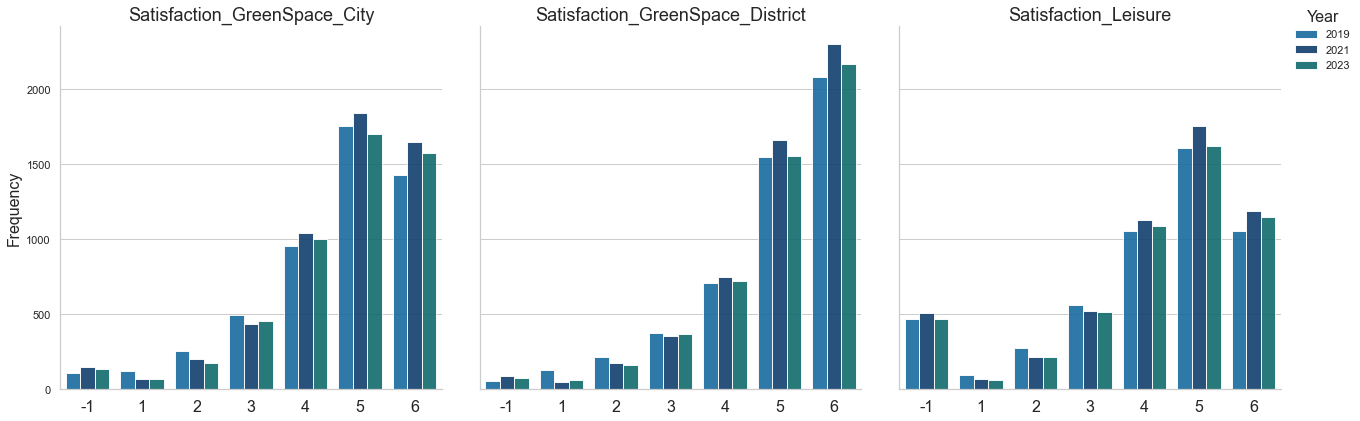

In [11]:
# reshape the data to long format
# long format explanation: each row represents a single observation of satisfaction level for a given category and year
df_long = df.melt(id_vars=['Year'], value_vars=ordinal_columns, var_name='Variable', value_name='Satisfaction')

# count the occurrences of each satisfaction level for each year and category
df_counts = df_long.groupby(['Year', 'Variable', 'Satisfaction']).size().reset_index(name='Count')

# define the custom colors for the years
year_colors = {
    2019: "#0070B4", 2021: "#00407C", 2023: "#00797B"
}

# create nested barplot
g = sns.catplot(
    data=df_counts, kind="bar",
    x="Satisfaction", y="Count", hue="Year",
    col="Variable", col_wrap=3,
    height=6, aspect=1, palette=year_colors, alpha=.9,
)

# adjust titles and label sizes
g.set_axis_labels("", "Frequency")
plt.subplots_adjust(wspace=0.1, hspace=0.5)
for ax in g.axes.flat:
    title = ax.get_title()
    ax.set_title(title.split('= ')[-1], fontsize=18)
    ax.set_ylabel(ax.get_ylabel(), fontsize=16)
    ax.tick_params(axis='x', labelsize=16)
    
# adjust legend title and font size
for text in g.legend.texts:
    text.set_fontsize(16)  # font size legend text
g.legend.set_title("Year", prop={'size': 16})
sns.move_legend(g, "upper right")

plt.show()

#### Interpretation

Die Barplots zeigen die Verteilung der Zufriedenheit über verschiedene Variablen. Auf der X-Achse sind die Zufriedenheitsstufen dargestellt, während die Y-Achse die Anzahl der Beobachtungen angibt. Die Balken sind nach Jahren gruppiert, um die Veränderungen über die sechs Jahre zu verdeutlichen. Folgende Erkenntnisse wurden festgehalten:

Über die sechs Jahre hinweg wurden keine grossen Unterschiede festgestellt; die Trends der Zufriedenheit pro Jahr sind bei allen Variablen ähnlich. Im Jahr 2021 war im Allgemeinen die höchste Zufriedenheit zu verzeichnen, gefolgt von 2023, wobei die Unterschiede minimal sind. Daher konzentrieren wir uns in weiteren Analysen auf das aktuellste Jahr 2023.

Es ist auch erkennbar, dass die Zufriedenheit mit dem Grünraum im Quartier im Vergleich zur Zufriedenheit mit Grünanlagen und Parks in der Stadt Zürich generell höher ist. Bei der Zufriedenheit mit der Freizeitgestaltung im Quartier gab es viele Enthaltungen oder Unentschiedenheiten, und sie wird etwas schlechter bewertet als die beiden anderen Variablen.

### 2.2 Zusammenhänge der Variabeln (Contingency Table as Heatmap)

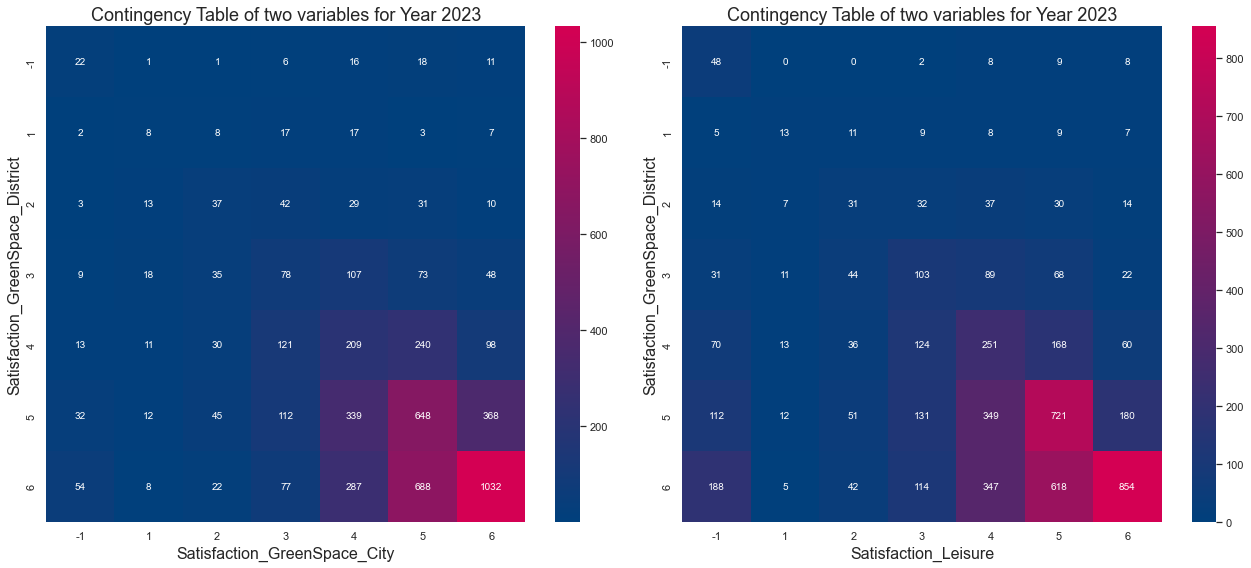

In [12]:
# filter data for the year 2023
df_2023 = df[df['Year'] == 2023]

# define the custom colors for the heatmap based on https://www.zh.ch/de/webangebote-entwickeln-und-gestalten/inhalt/designsystem/design-grundlagen/farben.zhweb-noredirect.zhweb-cache.html?
custom_cmap = sns.blend_palette(["#00407C", "#D40053"], as_cmap=True)

# function to create and plot a heatmap for given variables
def plot_heatmap(var1, var2, ax):
    # create a contingency table
    contingency_table_all = pd.crosstab(df_2023[var1], df_2023[var2])
    
    # plot the heatmap
    sns.heatmap(contingency_table_all, annot=True, cmap=custom_cmap, fmt='d', ax=ax)
    ax.set_title(f'Contingency Table of two variables for Year 2023', fontsize=18)
    ax.set_xlabel(var2, fontsize=16)
    ax.set_ylabel(var1, fontsize=16)

# create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# plot the first heatmap: Satisfaction_GreenSpace_District vs Satisfaction_GreenSpace_City
plot_heatmap('Satisfaction_GreenSpace_District', 'Satisfaction_GreenSpace_City', ax=axes[0])

# plot the second heatmap: Satisfaction_GreenSpace_District vs Satisfaction_Leisure
plot_heatmap('Satisfaction_GreenSpace_District', 'Satisfaction_Leisure', ax=axes[1])

# adjust layout
plt.tight_layout()
plt.show()

#### Interpretation

Die Contingency Tables, die als Heatmaps visualisiert wurden, zeigen die Beziehung zwischen den Zufriedenheitsniveaus verschiedener Variablen im Jahr 2023. Jede Zelle in der Heatmap repräsentiert die Anzahl der Beobachtungen für eine bestimmte Kombination der beiden Variablen und bietet einen visuellen Einblick in deren Beziehung.

Beim Vergleich der Zufriedenheit mit Grünräumen im Quartier und in der Stadt zeigt sich ein deutlicher Zusammenhang: Personen, die mit dem einen zufrieden sind, neigen auch dazu, mit dem anderen zufrieden zu sein. Es gibt eine Tendenz, dass Personen, die mit den Parkanlagen im Quartier sehr zufrieden sind, etwas weniger zufrieden mit den Parks und Grünanlagen in der Stadt sind.

Generell sind Personen, die mit dem Grünraum im Quartier zufrieden sind, tendenziell auch mit ihrer Freizeitgestaltung zufrieden, jedoch gibt es hier etwas mehr Variation und gelegentlich etwas höhere Unzufriedenheit.

# 3. Hypothesen

### 3.1 Hypothese 1

### 3.2 Hypothese 2

### 3.3 Hypothese 3

# 4. Fazit und Ausblick